In [6]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [1]:
import torch


class Energy(torch.nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self._dim = dim
        
    @property
    def dim(self):
        return self._dim
    
    def _energy(self, x):
        raise NotImplementedError()
        
    def energy(self, x, temperature=None):
        assert x.shape[-1] == self._dim, "`x` does not match `dim`"
        if temperature is None:
            temperature = 1.
        return self._energy(x) / temperature
    
    def force(self, x, temperature=None):
        x = x.requires_grad_(True)
        e = self.energy(x, temperature=temperature)
        return -torch.autograd.grad(e.sum(), x)[0]

In [22]:
class DoubleWellEnergy(Energy):
    def __init__(self, dim, a=0, b=-4., c=1.):
        super().__init__(dim)
        self._a = a
        self._b = b
        self._c = c
    
    def _energy(self, x):
        d = x[:, [0]]
        v = x[:, 1:]
        e1 = self._a * d + self._b * d.pow(2) + self._c * d.pow(4)
        e2 = 0.5 * v.pow(2).sum(dim=-1, keepdim=True)
        return e1 + e2
    
    def log_prob(self, x):
        return -self._energy(x)

In [23]:
import matplotlib.pyplot as plt

In [24]:
target = DoubleWellEnergy(2, a=-0.5, b=-6)

In [25]:
from Utils import plot_distribution

In [29]:
dist = plot_distribution(target, bounds=[[-3, 3], [-3, 3]], n_points=300)

# Let's fit with KL

In [30]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions, plot_samples
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation, plot_distribution
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.experimental.train_AIS import AIS_trainer
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
import torch

In [31]:
# setup expectation function
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)

In [40]:
dim=2
n_samples_estimation = int(1e3)
torch.manual_seed(0) # 0
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=5) # , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") 
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

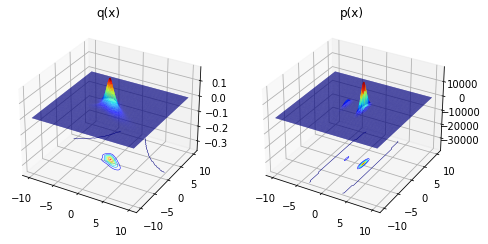

In [41]:
fig_before_train = plot_distributions(tester)

In [42]:
history = tester.train(10000, batch_size=100) # epochs 1000

loss: -10.129439353942871, mean log p_x 8.921310424804688: 100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:40<00:00, 62.35it/s]


In [43]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 32047.458984375 
estimate after training is 2856.593017578125 
effective sample size before is 0.0020687789656221867 out of 1000 
effective sample size after is 0.006538321264088154 out of 1000  
variance in weights is 0.00015194460866041481


In [44]:
plot_history(history)

(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

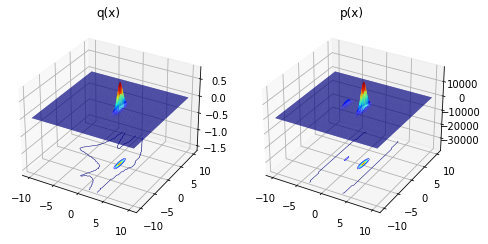

In [45]:
fig_after_train = plot_distributions(tester)